### SCIF30003: Advanced Data Science for Scientific Computing 
Exercise 3 – Assessment of Topics 2 and 3  

Using the Exoplanet Data

In [233]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.formula.api import logit

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.signal import peak_widths

__Reading in the data__

In [234]:
data = pd.read_csv("exoplanet-dataset.csv")

#The name of the exoplanet is not important so this was removed and stored in a seperate dataframe
names = data["Name"]

#The data has a weird column on the end that was filled with NaNs called "Unamed:12"
#This column and the name column were removed from the working dataframe called data
data = data.iloc[:,1:-1] 
data = data.rename(columns={"M-dwarf" : "M_dwarf"})

data.head()

,mass,radius,orbital_period,semi_major_axis,eccentricity,inclination,star_distance,star_mass,star_radius,star_teff,M_dwarf
0,20.00000,0.9200,7340.000000,3.530000,0.2600,46.20,25.00,0.080,0.100,2300.0,0
1,30.00000,1.3000,8686.000000,4.480000,0.0000,44.30,26.67,0.130,0.110,2350.0,0
2,0.47000,1.9000,4.230800,0.052000,0.0069,80.00,14.70,1.110,1.266,5793.0,0
3,0.02703,0.1737,0.736548,0.015439,0.0280,90.36,12.34,1.015,0.980,5196.0,0
4,0.03680,0.3908,8.463000,0.064500,0.0400,89.03,9.79,0.500,0.750,3700.0,0


In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mass             734 non-null    float64
 1   radius           734 non-null    float64
 2   orbital_period   734 non-null    float64
 3   semi_major_axis  734 non-null    float64
 4   eccentricity     734 non-null    float64
 5   inclination      734 non-null    float64
 6   star_distance    734 non-null    float64
 7   star_mass        734 non-null    float64
 8   star_radius      734 non-null    float64
 9   star_teff        730 non-null    float64
 10  M_dwarf          734 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 63.2 KB


For any models we're going to make, we don't want any NaN values, these values will be simply imputed using the mean strategy.

In [236]:
## There are 4 NaN values in the star_teff columns which we will fix with a simple imputation. Since the dataset is quite large, filling these values in with a mean should not affect the models created later.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(data)

_data = data
data = pd.DataFrame(imputed_data)
data.columns = _data.columns

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mass             734 non-null    float64
 1   radius           734 non-null    float64
 2   orbital_period   734 non-null    float64
 3   semi_major_axis  734 non-null    float64
 4   eccentricity     734 non-null    float64
 5   inclination      734 non-null    float64
 6   star_distance    734 non-null    float64
 7   star_mass        734 non-null    float64
 8   star_radius      734 non-null    float64
 9   star_teff        734 non-null    float64
 10  M_dwarf          734 non-null    float64
dtypes: float64(11)
memory usage: 63.2 KB


__Looking at the source of the data__

The catalog from which this data came for was found at "http://exoplanet.eu/catalog/".

The website tells us what each of the columns represent:
- Mass : Is the mass of the planet in Jupiter Masses.
- Radius : Is the radius of the planet in Jupiter Radius'.
- Orbital Period : Is the Amount of days it takes to orbit it's star.
- Semi Major Axis : Is the distance of its longest diameter in its orbit from it's star in AU Astronomical Units.
- Eccentricity : The dimensionless value that determiens the amount by which its orbit around it's start deviates from a perfect circle.
- Inclination : A measure of the planet's tilt around the star, expressed as an angle between a reference plane and the orbital plane. In degrees.
- Star Distance : Distance to it's host star in parsecs from Earth.
- Star Mass : Mass of it's star in Sun Masses.
- Star Radius : Radious of it's star in Sun Radius'.
- Star Effective Temperature : The effective temperature of it's star in Kelvin.

__Part 1 : Binary Logistical Regression__

Create and evaluate a BLR model where “star type” (i.e. M_dwarf or otherwise) is the target variable.  
 
You should start by considering how many possible BLR models could be created (i.e. how many 
possible combinations of independent variables there are). By performing suitable exploratory data 
analysis on the dataset (cf. Topic 1) and considering the scientific context, select a suitable 
combination of independent variables (no more than 6).  
 
You should evaluate the accuracy and limitations of your model

__Considering how many possible models could be created with the variables that we have__

In [237]:
n = 10 #10 indepentend variables in this feature set, this is once the M_dwarf column has been removed as this will be the dependent variable in the BLR.

count = 0
for r in range(1,7): # Up to six independent variables.
    count += math.comb(n,r)

print (f"There are {count} combinations for a model.")

There are 847 combinations for a model.


It is important to use data analysis and make our own judgements on what combinations would make the best model rather than creating 847 models and comparing them to see which one performs the best, as this is a waste of time and resources. 

__Scientific Insights__

Firstly, what is a dwarf star?
- Dwarf star is a star of relatively small size, mass and low luminosity. Most main sequence stars are dwarf stars

How are dwarf stars classified?
- A star is classified as a dwarf based on its small size, relatively low luminosity, and spectral characteristics.
- An M-dwarf is a dwarf star that fits into the main-sequence stars in stellar class M.

Important Notes:
- Luminosity of a star is proportional to its Effective Temperature to the 4th power and its radius squared.

Conclusion:
- We can therefore expect that the main indicators in whether a data point (exoplanet) is orbiting a M_dwarf star or not are the properties relating to the star itself such as the star's mass, radius and effective temperature.



We can explore this hypothesis more using a correlation map to see the relationships between the variables and the M-dwarf variable

In [238]:
corr = data.corr()["M_dwarf"]
corr

mass              -0.024483
radius            -0.365156
orbital_period    -0.012061
semi_major_axis   -0.015450
eccentricity      -0.004205
inclination        0.101705
star_distance     -0.249020
star_mass         -0.585075
star_radius       -0.412405
star_teff         -0.642926
M_dwarf            1.000000
Name: M_dwarf, dtype: float64

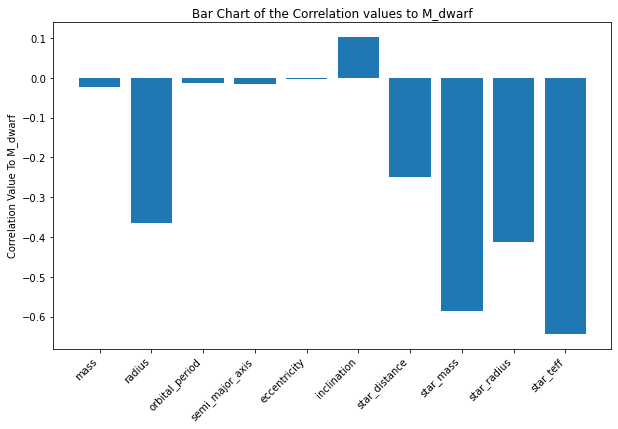

In [239]:
plt.figure(figsize=(10,6))
plt.bar(corr.index.values[:-1],corr.values[:-1])
plt.title("Bar Chart of the Correlation values to M_dwarf")
plt.ylabel("Correlation Value To M_dwarf")
plt.xticks(rotation=45, ha='right')
plt.show()

This hypothesis is correct on first glance. The columns related to the star itself are the best indicators on whether the exoplanet is orbiting an M_dwarf or not. However the radius data also has a significant correlation, however this could be due to a correlation between radius and one of the star columns.

Lets have a general overlook at this correlation data

All of the correlations apart from inclination are negative, meaning that as these variables increase, the likelihood of the star being an M-dwarf decreases.

Correlations in weight order:

Star Effective Temperature:

- Knowing the effective temperature of a star can help us determine if it is an M_dwarf because M_dwarfs are characterized by their relatively low temperatures. 

- In addition to their temperature, M_dwarfs are also smaller and less massive than other types of stars, which makes them less luminous. This is because they have less fuel to burn, which means they produce less energy and radiation.

Star Mass:
- The mass of a star is a key factor in determining its properties and evolution. For M_dwarfs, their lower mass is one of the key characteristics that sets them apart from other types of stars, and helps astronomers identify them as a distinct spectral type.

Star Radius:
- For M_dwarfs, their smaller radius is one of the key characteristics that sets them apart from other types of stars,

Planet Radius:
- The radius of an exoplanet orbiting a star can help astronomers determine the properties of the star, including whether it is an M_dwarf or not. This is because exoplanets orbiting M_dwarfs tend to have smaller radii compared to planets orbiting other types of stars.
- In the case of planets orbiting M_dwarfs, the smaller radius of the planet suggests that it is orbiting a smaller star with a smaller radius. This is because smaller stars have a weaker gravitational pull and can only hold smaller planets in close orbits.

- One reason for the negative radius correlation could be that "Young M dwarfs are extremely active and exhibit high-intensity XUV radiation, which affects the inner planets and can potentially strip away the atmospheres of gaseous planets to leave rocky cores" from https://iopscience.iop.org/article/10.3847/1538-4357/ab334c. 

- The distance of an exoplanet from its star helps us determine the characteristics of the star it orbits, including its type. 

- When an exoplanet orbits an M_dwarf, it can cause the star to wobble slightly, which can be detected by astronomers. By measuring the size and frequency of this wobble, astronomers can determine the mass of the star, as well as the distance of the exoplanet from the star.

- When an exoplanet is located very close to its star, this is a strong indicator that the star is an M_dwarf. M_dwarfs are much smaller and cooler than other types of stars, so their habitable zones - the region around a star where temperatures are suitable for liquid water to exist on the surface of an orbiting planet - are much closer to the star. As a result, planets orbiting M_dwarfs are more likely to be located very close to their star.


Star Distance From Earth:

- It seems as when a star gets further away from Earth, the less likely it is to be an M_dwarf. However this is only true for the data so this could be rephrased as saying, the further away a star is from Earth, the less amount of M_dwarfs will be detected relative to other stars, which woud make sense as when we explored what an M_dwarf is we saw that they have lower size and luminosity than other stars which would likely result in a more difficult detection, especially at large distances.



With the most impactful independent variables listed above we can start to build a model for predicting whether an exoplanet is orbiting an M_dwarf star or not. However before performing logistic regression, it's important to check for multicollinearity (high correlation between independent variables) and remove any unnecessary variables to avoid overfitting. You can also perform feature selection to identify the most important predictors.

[Text(0.5, 0, 'mass'),
 Text(1.5, 0, 'radius'),
 Text(2.5, 0, 'orbital_period'),
 Text(3.5, 0, 'semi_major_axis'),
 Text(4.5, 0, 'eccentricity'),
 Text(5.5, 0, 'inclination'),
 Text(6.5, 0, 'star_distance'),
 Text(7.5, 0, 'star_mass'),
 Text(8.5, 0, 'star_radius'),
 Text(9.5, 0, 'star_teff'),
 Text(10.5, 0, 'M_dwarf')]

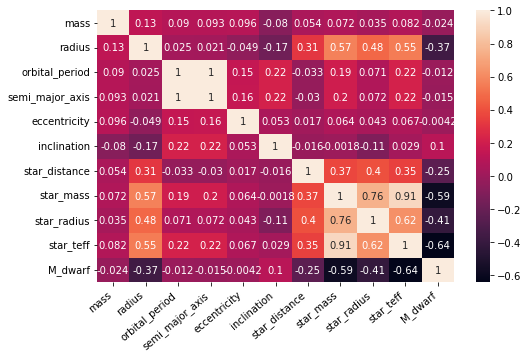

In [240]:
data.corr()
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(data.corr(), annot=True,ax=ax)
ax.set(xlabel="", ylabel="")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

From this plot we can see that there is a box of high correlation around the star variables which are also the most correlated to the m_dwarf column as seen before. The highest correlation is between star_teff and star_mass which have an extremly high value of 0.91. These two features should therefore not be used in a BLR model at the same time in order to avoid an problems due to multiocllinearity and in order to be able to trust that the p-values are significantly significant.

Here we confirm what we suspected earlier : that the radius column was related to the star varaibles.

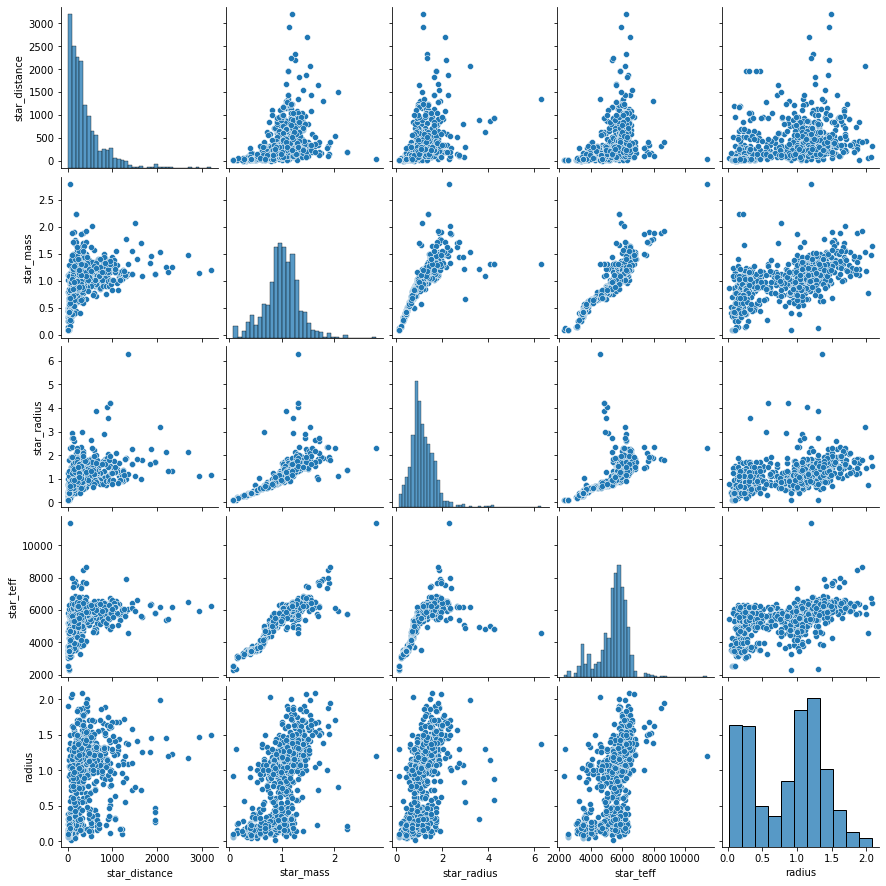

In [241]:
vars = ['star_distance', 'star_mass','star_radius', 'star_teff', 'radius']
sns.pairplot(data=data, vars=vars)

This is a plot of the independent variables with the largest correlations to the M-dwarf varaible.

The historgrams show how the data in each variable is distrubuted:
- Star_distance shows us almost a beta distribution and shows that most of the data is for stars with a relatively low distance with only a handfull of datapoints a larger distances.
- Star_mass shows a normal distribution with a mean of 1 sun mass.
- Star_radius shows a very steep and narrow normal distrubtion around 1 sun radius'.
- Star_teff shows another normal distribution around 5600.
- No identifiable relation with planet radius.

Star distance does not have a clear correlation with any of the other variables as expected as the other variables should be independent of where their system is from Earth.


Star Mass has a linear relationship with both star_radius and star_teff.
- This would be expected as when the star are larger in volume (greater radius) we would usually expect the mass to increase.
- As star_mass increases, fusion happens more rapidly and therefore produce more heat and are hotter than low mass stars.
- No relation with planet radius.

Star Radius has an interesting relation to star_teff, at low temperatures, the relation between the radius and teff is linear, so as the radius gets bigger, so does the teff.
- This can be explained due to the fact that bigger stars produce more energy and therefore they tend to be hotter.
- No relation with planet radius.
- However the linear relationship disperses when reaching effective temperatures of around 6000. There is not longer a clear relationship at this point and this is shown by the data points following completely different paths to eachother past this temperature.

__Create and evaluate a BLR model where “star type” is the target variable__

Analysis the data with respect to the M_dwarf variable.

In [242]:
data["M_dwarf"].value_counts()

0.0    675
1.0     59
Name: M_dwarf, dtype: int64

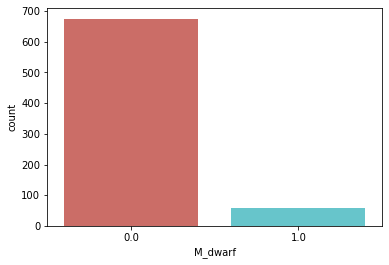

In [243]:
sns.countplot(x="M_dwarf",data=data,palette="hls")
plt.show()

In [244]:
count_no_sub = len(data[data['M_dwarf']==0])
count_sub = len(data[data['M_dwarf']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of not M_dwarf is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of M_dwarf", pct_of_sub*100)

percentage of not M_dwarf is 91.96185286103542
percentage of M_dwarf 8.038147138964577


The classes are imbalanced, and the ratio of not M_dwarf to M_dwarf instances is 92:8.

In [245]:
data.groupby("M_dwarf").mean()

,mass,radius,orbital_period,semi_major_axis,eccentricity,inclination,star_distance,star_mass,star_radius,star_teff
M_dwarf,,,,,,,,,,
0.0,1.685479,0.923339,359.785157,0.256015,0.094306,86.792654,417.701417,1.061403,1.210688,5617.357953
1.0,1.199655,0.234556,7.536287,0.046098,0.092037,88.734042,46.929639,0.349288,0.359742,3348.135593


Observations:
- The mass of an M_dwarf is on average lower than that of the other stars.
- The average radius of a exoplanet orbiting an M_dwarf is on average almost 4 times smaller than that of those orbiting a different star type.
- The average orbital_period of a exoplanet orbiting an M_dwarf is much lower than for those that are orbiting a different star type.
- The Semi_major axis on average is roughly 5 times smaller for planets orbiting an M_dwarf on average.
- On average the eccentricity is roughly the same for planets orbiting both M_dwarfs and other types of stars.
- On average, exoplanets orbiting M_dwarfs are much closer to Earth (almost 10 times closer) than for regular stars.
- The average star mass for an M_dwarf is 30% of what the average is for not an M_dwarf.
- The average radius of an M_dwarf is 4 times smaller than the radius of not an M_dwarf.
- The effective temperature of an M_dwarf is roughly 60% of the effective temperature of not an M_dwarf.

Creating a BLR model

Computing a preliminary BLR model with the highest correlation independant variable.

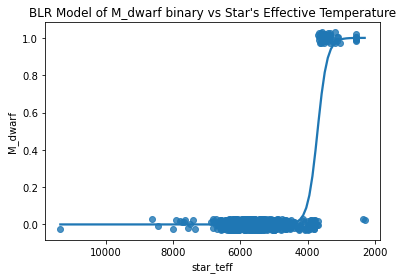

In [246]:
sns.regplot(x = "star_teff", y = "M_dwarf",
            y_jitter=0.03,
            data=data,
            logistic=True, 
            ci = None)
plt.title("BLR Model of M_dwarf binary vs Star's Effective Temperature")
plt.gca().invert_xaxis()
plt.show()

Note that in the plot the x axis has been inverted in order to show the natural direction of the sigmoid function.

From the plot it looks as though this model is not terrible at predicting whether the star is an M_dwarf or not, however there are two outlying points around the 2000 temperature value.

Now we will fit a logistic regression using the statsmodel api on a dataset that has been split into test and training datasets.

In [247]:
train_data, test_data = train_test_split(data, test_size=0.40, random_state = 42)

In [248]:
trial_eq = ('M_dwarf ~ star_teff')
model_teff = logit(formula=trial_eq, data=train_data).fit()

Optimization terminated successfully.
         Current function value: 0.069347
         Iterations 11


In [249]:
model_teff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                M_dwarf   No. Observations:                  440
Model:                          Logit   Df Residuals:                      438
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.7502
Time:                        09:47:00   Log-Likelihood:                -30.513
converged:                       True   LL-Null:                       -122.17
Covariance Type:            nonrobust   LLR p-value:                 9.162e-42
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.9252      4.071      4.648      0.000      10.946      26.905
star_teff     -0.0052      0.001     -4.670      0.000      -0.007      -0.003
==============================================================================

Possibly complete quasi-separation: A fraction 0.58 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Looking at the P>|z| value in the summary we can see that the star_teff variable is significant in the model as it has a value of 0.0.

For future models we will take 5% as a level of significance meaning that any parameter with less than 0.05 in the P>z column should be removed as it is overfitting/ interfereing with the model.

BLR models do not need to be between the binary dependent varaible and just one other independent vairables. You can build models which have multiple independent variables. However as discussed earlier, if the independent variables are heavily correlated with eachother they will reduced the statisitcal significance of the model.

This will be demonstrated with the star_teff and the star_mass_.

In [250]:
train_data, test_data_both = train_test_split(data, test_size=0.40, random_state = 42)

trial_eq = ('M_dwarf ~ star_teff+star_mass')
model_both = logit(formula=trial_eq, data=train_data).fit()

model_both.summary()

Optimization terminated successfully.
         Current function value: 0.063948
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                M_dwarf   No. Observations:                  440
Model:                          Logit   Df Residuals:                      437
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.7697
Time:                        09:47:00   Log-Likelihood:                -28.137
converged:                       True   LL-Null:                       -122.17
Covariance Type:            nonrobust   LLR p-value:                 1.453e-41
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1266      4.708      2.151      0.031       0.899      19.354
star_teff     -0.0011      0.002     -0.571      0.568      -0.005       0.003
star_mass    -12.5896      6.082     -2.070      0.038     -24.509      -0.670
==============================================================================

Possibly complete quasi-separation: A fraction 0.45 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

This model is built using those two variables together and you can now see that the P>z value has increased significantly on the star_teff parameter. With a P value of 0.569 this is significantly over the 5% significance level. This shows that highly correlated variables should not be combined together to create a successful model.

We can build up our model and remove the variables while there are vairables with a P value of greater than 0.05.

We can look at confusion matrix's of the models in order to define the perfomance.

In [251]:
#Compute prediction with our model.
prediction = model_both.predict(exog=test_data)

cutoff = 0.50 

#Compute class predictions: y_prediction 
y_prediction = np.where(prediction>cutoff, 1, 0)

#Assign actual class labels from the test sample to y_actual
y_actual = test_data["M_dwarf"]

#Compute and print confusion matrix using crosstab function
conf_matrix = pd.crosstab(y_actual, y_prediction, 
                         rownames =["Actual"], 
                         colnames =["Predicted"], 
                         margins = True)

print(conf_matrix)

Predicted    0   1  All
Actual                 
0.0        270   0  270
1.0          5  19   24
All        275  19  294


In [252]:
acc = accuracy_score(y_actual, y_prediction)
print(acc)

0.9829931972789115


This confusion matrix shows us that this model predicted 270/270 non-M_dwarfs correctly and 5/24 M_dwarf's correctly.
Since we are looking to identify M_dwarfs, getting  roughly 20% of the data points wrong shows that the model is currently not a good model. However the accuracy score takes into account the whole dataset and therefore the model seems relatively good. This is an example of where you can't fully trust the accuracy score when you are focussing on certain features of the data.

However if we look at the model before where there was no multilinearity we would expect a better performance:

In [253]:
#Compute prediction with our model.
prediction = model_teff.predict(exog=test_data)

cutoff = 0.50 

#Compute class predictions: y_prediction 
y_prediction = np.where(prediction>cutoff, 1, 0)

#Assign actual class labels from the test sample to y_actual
y_actual = test_data["M_dwarf"]

#Compute and print confusion matrix using crosstab function
conf_matrix = pd.crosstab(y_actual, y_prediction, 
                         rownames =["Actual"], 
                         colnames =["Predicted"], 
                         margins = True)

print(conf_matrix)

Predicted    0   1  All
Actual                 
0.0        270   0  270
1.0          0  24   24
All        270  24  294


In [254]:
acc = accuracy_score(y_actual, y_prediction)
print(acc)

1.0


And as expected the perfomance is better with a 100% success rate and therefore an accuracy of 1.

Now we will attempt to make a model with a few indicators picked based on the scientific context:

Since the most significant correaltion to the M_dwarf value was star_teff we will include this variable in our model however using this value means that we will avoid the varaibles that are highly correlated with it usch as star_distance, star_mass, radius, and star_distance. Therefore we will use the only other independant variable which as a semi-significant correlation with the M_dwarf column.

In [255]:
train_data, test_data = train_test_split(data, test_size=0.40, random_state = 42)

trial_eq = ('M_dwarf ~ star_teff+inclination')
model = logit(formula=trial_eq, data=train_data).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.012067
         Iterations 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                M_dwarf   No. Observations:                  440
Model:                          Logit   Df Residuals:                      437
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.9565
Time:                        09:47:01   Log-Likelihood:                -5.3094
converged:                       True   LL-Null:                       -122.17
Covariance Type:            nonrobust   LLR p-value:                 1.772e-51
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      16.3408     11.350      1.440      0.150      -5.905      38.587
star_teff      -0.0279      0.011     -2.599      0.009      -0.049      -0.007
inclination     0.9824      0.366      2.683      0.007       0.265       1.700
===============================================================================

Possibly complete quasi-separation: A fraction 0.90 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Looking at the P values, both this parameters are less than the 5% set significance level, they are therefore suitable to be combined together in this model.

In [256]:
#Compute prediction with our model.
prediction = model.predict(exog=test_data)

cutoff = 0.50 

#Compute class predictions: y_prediction 
y_prediction = np.where(prediction>cutoff, 1, 0)

#Assign actual class labels from the test sample to y_actual
y_actual = test_data["M_dwarf"]

#Compute and print confusion matrix using crosstab function
conf_matrix = pd.crosstab(y_actual, y_prediction, 
                         rownames =["Actual"], 
                         colnames =["Predicted"], 
                         margins = True)

print(conf_matrix)

Predicted    0   1  All
Actual                 
0.0        270   0  270
1.0          0  24   24
All        270  24  294


In [257]:
acc = accuracy_score(y_actual, y_prediction)
print(acc)

1.0


Once again this model has 100% accuracy on the test set. 
The p values for both the independant varaibles are under the significance level and can therefore be used together.

Since this model has the same predicting power than our single independent varaible model it is beneficial to use the single independent varaible model as the final model as have fewer variables reduces the amount of overfitting on the data, understandability by the viewer is easier with the fewer variables as well as the productivity, for example if this model was going to be used again on a huge data set, we would rather clean one variable column than 2 in order to save time.

Therefore the final model is :

In [258]:
train_data, test_data = train_test_split(data, test_size=0.40, random_state = 42)

trial_eq = ('M_dwarf ~ star_teff')
model = logit(formula=trial_eq, data=train_data).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.069347
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                M_dwarf   No. Observations:                  440
Model:                          Logit   Df Residuals:                      438
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.7502
Time:                        09:47:01   Log-Likelihood:                -30.513
converged:                       True   LL-Null:                       -122.17
Covariance Type:            nonrobust   LLR p-value:                 9.162e-42
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.9252      4.071      4.648      0.000      10.946      26.905
star_teff     -0.0052      0.001     -4.670      0.000      -0.007      -0.003
==============================================================================

Possibly complete quasi-separation: A fraction 0.58 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=

Part 2 : Bayesian Distribution For Star Type

Let the variable 𝜃 denote the probability that a star is M_dwarf.  
a. For the whole dataset, compute the Posterior distribution for 𝜃 using a suitable likelihood 
and prior. You should consider the order in which you insert data and track how the most 
likely value of 𝜃 and the width of the posterior distribution changes as you insert data.  

First we need to determine what type of distributions the likelihood and the prior should be. 

In [259]:
#This randomises the locations of the data
dwarf_data = data["M_dwarf"]
dwarf_data = dwarf_data.sample(frac=1).reset_index(drop=True)

In [260]:
#Binomial dist for likelihood - given we look at n many stars, how many are dwarf x for our probability theta.
def binomial_likelihood(n,x,theta):
    f1 = np.power(theta,x)*(np.power((1-theta),(n-x)))
    f2 = np.math.factorial(n)/(np.math.factorial(x)*np.math.factorial(n-x))
    f = f1*f2
    return f

In [261]:
def plot_post(n,x,ax):
    npoints=1000
    _data = np.zeros((npoints,7))
    post_theta = []
    post_width = []

    for i in range(0,npoints,1):
        #i, theta, prior, likelihood
        _data[i,0] = i
        _data[i,1] = i/1000 # Moving in steps of 0.000 to 0.999
        _data[i,2] = 1.0 #Uniform distribution
        _data[i,3] = binomial_likelihood(n,x,_data[i,1]) 
 
    likelihood_area_1 =  (1/npoints)*np.sum(_data[:,3]) #Computing the normalization for the likelihood function
    _data[:,4] = _data[:,3]/likelihood_area_1 #Recomputing likelihood function which is now normalized and plotting it. 
    NB = np.dot(_data[:,2], _data[:,4]) #Prior*normalized likelihood
    _data[:,5] = (_data[:,4]*_data[:,2])/NB #Computing the initial posterior distribution 
    posterior_area_1 =  (1/npoints)*np.sum(_data[:,5]) #Finding the area under the initial Posterior distribution
    
    _data[:,6] = (_data[:,5])/posterior_area_1 #Computing final posterior distribution

    ax.plot(_data[:,1], _data[:,6], '+', label = count )
    
    #To find the most likely value for theta we find the value of theta at which the posterior is at a maximum. 
    posterior_final =  (1/npoints)*np.sum(_data[:,6])
    posterior_max = np.max(_data[:,6])
    index_max =_data[:,6].argmax(axis=0)
    theta_max = index_max/1000

    return [posterior_max, index_max, theta_max]

Here we are inserting the data points randomly one by one and calculating a new postierior each time.

The prior is a simple uniform distribution as the probability of a picked exoplanet orbiting an M_dwarf or not is simply a constant in the overall dataset.


The likelihood is a binomial distribution as the data we have provides an amount of checks (is this planet a Mdwarf or not) and an amount of successes (yes, this planet is an Mdwarf)

Posterior max = 35.04077290406022, Theta max = 0.085


Text(0, 0.5, 'Posterior')

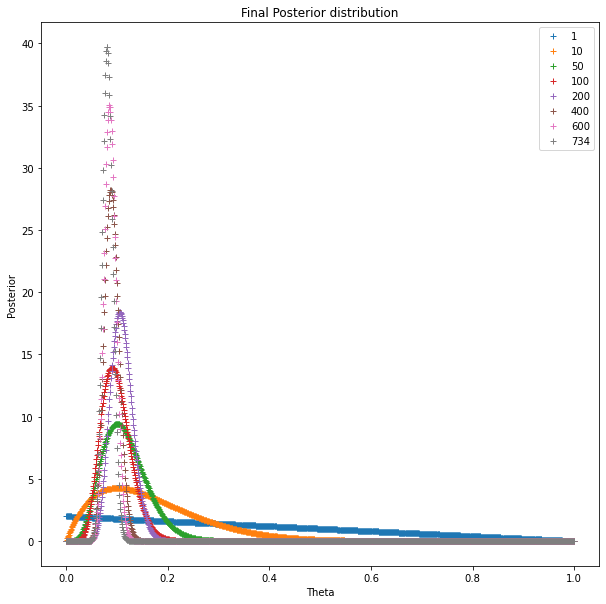

In [262]:
dwarf_count, count = 0,0
plots_at= [1,10,50,100,200,400,600,734]

fig, ax = plt.subplots(figsize=(10,10))

for i in dwarf_data:
    if i == 1:
        dwarf_count += 1
    count +=1 
    if count in plots_at:
        out = plot_post(count, dwarf_count,ax)

    if count == len(dwarf_data)-1:
        print(f"Posterior max = {out[0]}, Theta max = {out[2]}")
   

ax.legend()
ax.set_title("Final Posterior distribution")
ax.set_xlabel("Theta")
ax.set_ylabel("Posterior")

From the plot and the print statement we can see that as more data is added, the more defined the postier distribution becomes as the width of the distribtuion reduces and therefore the accuracy on our posterior value improves. We can see that the maximum posterior values tend to the theta value of the largest distribtuion. The theta value at the largest distribution is 0.083 which represents the probability of picking an M_dwarf exoplanet when picking a random exoplanet out of the dataset.


In [263]:
def get_data(n,x,theta_list, width_list):
    
    npoints=1000
    _data = np.zeros((1000,7))

    for i in range(0,npoints,1): #i, theta, prior, likelihood
        _data[i,0] = i
        _data[i,1] = i/1000 # Moving in steps of 0.000 to 0.999
        _data[i,2] = 1.0 #Uniform distribution
        _data[i,3] = binomial_likelihood(n,x,_data[i,1]) 

    #Computing the normalization for the likelihood function 
    likelihood_area_1 =  (1/npoints)*np.sum(_data[:,3])
    #Recomputing likelihood function which is now normalized. 
    _data[:,4] = _data[:,3]/likelihood_area_1
    #Computing the NB term
    NB = np.dot(_data[:,2], _data[:,4]) #Prior*normalized likelihood
    #Computing the initial posterior distribution 
    _data[:,5] = (_data[:,4]*_data[:,2])/NB
    #Finding the area under the initial Posterior distribution 
    posterior_area_1 =  (1/npoints)*np.sum(_data[:,5])

    #Computing final posterior distribution
    _data[:,6] = (_data[:,5])/posterior_area_1
 
    posterior_final =  (1/npoints)*np.sum(_data[:,6])
    posterior_max = np.max(_data[:,6])
    index_max =_data[:,6].argmax(axis=0)
    theta_max = index_max/1000

    theta_list.append(theta_max)
    
    width = peak_widths(_data[:,6], np.array([_data[:,6].argmax()]),rel_height=0.5)[0]
    width_list.append(width)
    


Now we want to track the theta position and the width: So use the get_data function defined above to populate the lists.

This function will take a while as it calculates the posterior after each data entry.

In [264]:
## Collecting the data
post_theta = []
post_width = []
counts = []

dwarf_count = 0
count = 0

for i in dwarf_data:
    if i == 1:
        dwarf_count += 1
    count +=1 
    counts.append(count)
    get_data(count,dwarf_count,post_theta, post_width)

C:\Users\georg\AppData\Local\Temp/ipykernel_1028/3635144412.py:33: PeakPropertyWarning: some peaks have a prominence of 0
  width = peak_widths(_data[:,6], np.array([_data[:,6].argmax()]),rel_height=0.5)[0]
C:\Users\georg\AppData\Local\Temp/ipykernel_1028/3635144412.py:33: PeakPropertyWarning: some peaks have a width of 0
  width = peak_widths(_data[:,6], np.array([_data[:,6].argmax()]),rel_height=0.5)[0]


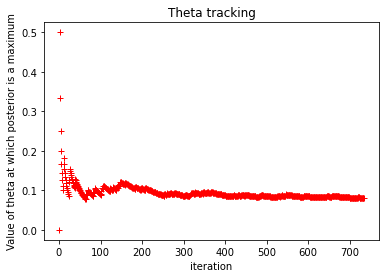

In [265]:
plt.plot(counts, post_theta, 'r+')
plt.title("Theta tracking")
plt.xlabel("iteration")
plt.ylabel("Value of theta at which posterior is a maximum")
plt.show()     

From the theta tracking we can see that at the beginning when the first few data points are being added that there is a large spontinuity to the theta value. However as more of the data gets inputted the changes in theta become more steady which can be seen by the lines becoming more defined. Towards the last few hundred iterations one can see that theta is beginning to converge to a single value. This value would be the probability that a picked exoplanet is orbiting an M_dwarf.

In [266]:
print(f"The theta value after all the iterations is : {post_theta[-1]}")

The theta value after all the iterations is : 0.08


The width of the posterior distribution can also be recorded. The width of the postierior distribution represents the error in the theta value. The width was calculated using a fullwidth at half maximum function.

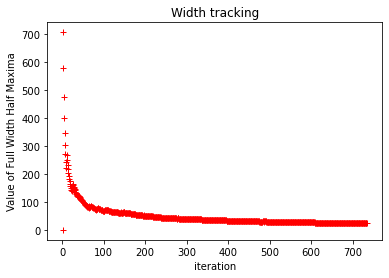

In [290]:
plt.plot(counts, post_width, 'r+')
plt.title("Width tracking")
plt.xlabel("iteration")
plt.ylabel("Value of Full Width Half Maxima")
plt.show()     

The width tracking data has similarities with the theta tracking data, both of the have large changes in their values at low iterations but as the iterations increase, so does the stability and the value ends up converging.

From this plot we can see that the accuracy of the theta value increases over time with an eventual convergence towards a certain value.

In [291]:
print(f"The width of the final posterior after all the iterations is : {post_width[-1][0]}")

The width of the final posterior after all the iterations is : 23.648710258357383


b. (More challenging). Now investigate how the posterior distribution changes as a function of 
distance from the exoplanet. Create suitable plots involving 𝜃 and distance to gain an initial 
impression of any trends: you should think about suitable “binning” of the distance variable 
according to the range of values and its distribution. It’s recommended to use a maximum of 
10 bins.  
 
As for part a), you should consider the order in which you insert data. Present a table 
showing the final most likely value of 𝜃 and the width of the posterior distribution for each 
distance “bin”.  
 
It is known that ~70% of stars within the local neighbourhood within our Galaxy are M_dwarfs. How 
do your results compare? Consider the limitations of the dataset and the biases in detection of 
exoplanets.

In [269]:
#The data we care about is only in the follow two columns
data = data[["star_distance", "M_dwarf"]]
data.describe()

,star_distance,M_dwarf
count,734.000000,734.000000
mean,387.898236,0.080381
std,405.089370,0.272068
min,6.550000,0.000000
25%,120.000000,0.000000
50%,276.150000,0.000000
75%,501.722500,0.000000
max,3200.000000,1.000000


So the star_distance goes from 6.55 to 3200 parsecs. We can also see how this data is distributed over the star_distance vairable.

<AxesSubplot:xlabel='star_distance', ylabel='Count'>

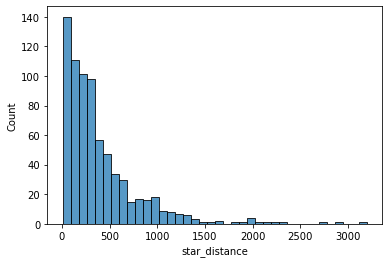

In [270]:
sns.histplot(data["star_distance"])

As can be seen above, most of the data lies between 0 and 500 with only a tiny amount of data points above 2500. It is therefore important to make sure the bins are large enough to have a significant amout of data in.

However the data we are mostly interested in is when the star is an M_dwarf. We will therefore take a look at the data when only considering exoplanets which orbit M_dwarfs.

In [271]:
mdwarf_data = data[data["M_dwarf"]==1]
mdwarf_data.describe()

,star_distance,M_dwarf
count,59.000000,59.0
mean,46.929639,1.0
std,51.975447,0.0
min,6.900000,1.0
25%,12.470000,1.0
50%,30.504300,1.0
75%,50.880000,1.0
max,279.000000,1.0


We can see from this description of the data that the maximum distance from Earth that an exoplanet has been detected is 279 parsecs.

The distribution of M_dwarf exoplanet data with star_distance is plotted below.

<AxesSubplot:xlabel='star_distance', ylabel='Count'>

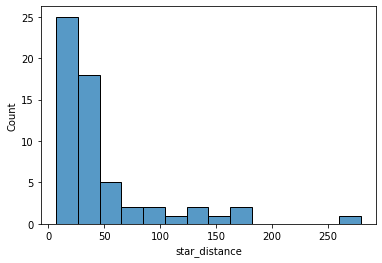

In [272]:
sns.histplot(mdwarf_data["star_distance"])

It is therefore not useful to use the data outside of this data range in order to find the most likely theta value as it will always be 0 as there are no M_dwarfs in that data.

The dataset will therefore be reduced to between distances of 0 and 300 parsecs.

In [273]:
data = data[data["star_distance"]<=300]
data.head()

,star_distance,M_dwarf
0,25.00,0.0
1,26.67,0.0
2,14.70,0.0
3,12.34,0.0
4,9.79,0.0


<AxesSubplot:xlabel='star_distance', ylabel='Count'>

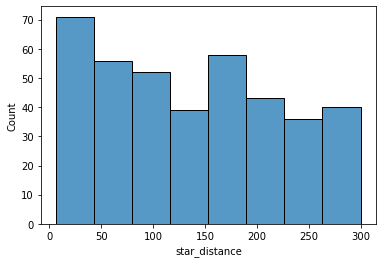

In [274]:
sns.histplot(data["star_distance"],bins=8)

<AxesSubplot:xlabel='star_distance', ylabel='Count'>

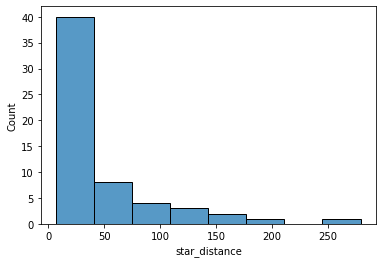

In [275]:
sns.histplot(data[data["M_dwarf"]==1]["star_distance"],bins=8)

8 bins were chosen in order to have a nice amount of data points for the end plot of distance vs theta. The one problem with choosing a higher bin count for this data set is that as the distance goes up, the amount of data that each bin gets to work with decreases.

One way that this data could be binned up is by having bin sizes of equal numbers of data points. This would work however it would shift the distance values of the data points down towards the low star_distances and leave a low number of data points at the high distances.

Comparing the plots above which show the overall star count vs the M_dwarf star count shows that there is a relation between M_dwarfs and star_distance in our data set. A fist hypothesis would be that the further the star_distance the lower the probability that a star is an M_dwarf.

The data is first split into 8 bins chosen in order to get a nicer plot of distance vs theta.

In [276]:
dist = data["star_distance"].max()
eighth = dist/8

data.loc[data['star_distance'].between(0, eighth, 'right'), 'id'] = 1
data.loc[data['star_distance'].between(eighth, 2*eighth , 'right'), 'id'] = 2
data.loc[data['star_distance'].between(2*eighth, 3*eighth, 'right'), 'id'] = 3
data.loc[data['star_distance'].between(3*eighth, 4*eighth,  'right'), 'id'] = 4
data.loc[data['star_distance'].between(4*eighth, 5*eighth , 'right'), 'id'] = 5
data.loc[data['star_distance'].between(5*eighth, 6*eighth , 'right'), 'id'] = 6
data.loc[data['star_distance'].between(6*eighth, 7*eighth, 'right'), 'id'] = 7
data.loc[data['star_distance'].between(7*eighth, dist,  'right'), 'id'] = 8
data.head()

,star_distance,M_dwarf,id
0,25.00,0.0,1.0
1,26.67,0.0,1.0
2,14.70,0.0,1.0
3,12.34,0.0,1.0
4,9.79,0.0,1.0


We can see how the data has been distributed into the various bins.

<AxesSubplot:xlabel='id', ylabel='Count'>

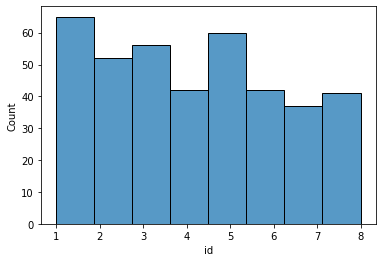

In [277]:
sns.histplot(data["id"],bins=8)

<AxesSubplot:xlabel='star_distance', ylabel='Count'>

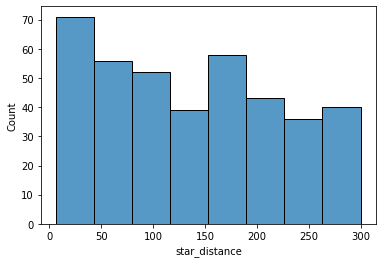

In [278]:
sns.histplot(data["star_distance"],bins=8)

Which matches up with the histogram plotted before. This confirms that our data has been correctly seperated into bins.

Now that the data has been distributed into bins we want to work out the theta value for each of the bins.


In [279]:
def get_theta_width(n,x):
    
    npoints=1000
    _data = np.zeros((1000,7))

    for i in range(0,npoints,1): #i, theta, prior, likelihood
        _data[i,0] = i
        _data[i,1] = i/1000 # Moving in steps of 0.000 to 0.999
        _data[i,2] = 1.0 #Uniform distribution
        _data[i,3] = binomial_likelihood(n,x,_data[i,1]) 
     
    likelihood_area_1 =  (1/npoints)*np.sum(_data[:,3])
    
    _data[:,4] = _data[:,3]/likelihood_area_1
   
    NB = np.dot(_data[:,2], _data[:,4])
    
    _data[:,5] = (_data[:,4]*_data[:,2])/NB
    
    posterior_area_1 =  (1/npoints)*np.sum(_data[:,5])

    _data[:,6] = (_data[:,5])/posterior_area_1
 
    index_max =_data[:,6].argmax(axis=0)
    theta_max = index_max/1000

    #plt.plot(_data[:,1],_data[:,6])
    width = peak_widths(_data[:,6], np.array([_data[:,6].argmax()]),rel_height=0.5)[0][0]

    return [theta_max, width]

In [280]:
def get_values(data,ids,post_thetas,widths):

    for i in ids:
        working_data = data[data["id"]==i]["M_dwarf"]
        working_data = working_data.sample(frac=1).reset_index(drop=True) #Randomising indexs

        dwarf_count = 0
        count = 0

        for j in working_data:
            if j == 1:
                dwarf_count += 1
            count +=1 

        results = get_theta_width(count,dwarf_count)
        post_thetas.append(results[0])   
        widths.append(results[1])

In [281]:
ids = np.arange(1,9,1) # 8 binds
post_theta = []
widths = []

get_values(data, ids, post_theta, widths)

C:\Users\georg\AppData\Local\Temp/ipykernel_1028/1785224800.py:28: PeakPropertyWarning: some peaks have a prominence of 0
  width = peak_widths(_data[:,6], np.array([_data[:,6].argmax()]),rel_height=0.5)[0][0]
C:\Users\georg\AppData\Local\Temp/ipykernel_1028/1785224800.py:28: PeakPropertyWarning: some peaks have a width of 0
  width = peak_widths(_data[:,6], np.array([_data[:,6].argmax()]),rel_height=0.5)[0][0]


The functions above allow us to calculate the theta value at which the posterior is at its maximum. This data will now be plotted and we will be able to get an idea as to how the theta value changes over star_distance.

Text(0, 0.5, 'Theta Value')

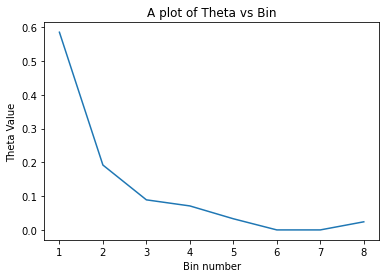

In [282]:
plt.plot(ids,post_theta)
plt.title("A plot of Theta vs Bin")
plt.xlabel("Bin number")
plt.ylabel("Theta Value")

This graph shows that overall there is a large decrease in the probability of a chosen exoplanet orbiting an M_dwarf as the star_distance increases.
I will replace the bin number with the distance as this is what the data actually represents.

Each bin will have its average distance assigned to it. And then the graph shall be replotted.

Text(0, 0.5, 'Theta Value')

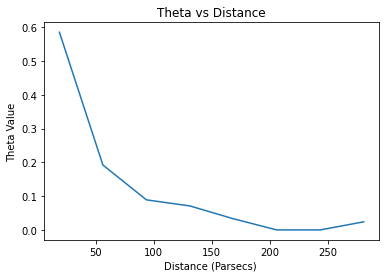

In [292]:
distances = np.arange(eighth/2,dist,eighth)

plt.plot(distances,post_theta)
plt.title("Theta vs Distance")
plt.xlabel("Distance (Parsecs) ")
plt.ylabel("Theta Value")

This plot shows us that the further away an exoplanet is detected, the less likely it is to be orbiting an M_dwarf star.

This suggests that there is a limitation on the distance of detecting M_dwarf stars which we know is true from our scientific research from above. The M_dwarf stars are smaller and less luminous which makes it harder to detect an exoplanet orbiting round them as the transit method (measuring the dimming of a star that happens when a plnet passes in front of it) compared to regular, brighter and more massive stars.



The width of the distribution vs the distance can also be plotted:

Text(0, 0.5, 'Width')

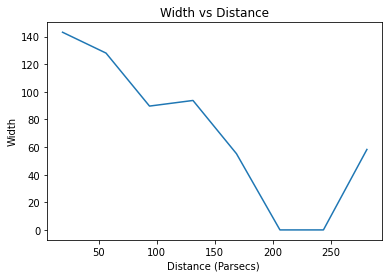

In [284]:
plt.plot(distances,widths)
plt.title("Width vs Distance")
plt.xlabel("Distance (Parsecs) ")
plt.ylabel("Width")

It should be noted that in this plot there are two points at 0. This is due to a lack of M_dwarf star data in this distance range, as there are no data points for M_dwarf, the posterior distribution is infitnely big and therefore so are their widths. These datapoints therefore do not carry any retractable information and therefore should be ignored.

Text(0, 0.5, 'Width')

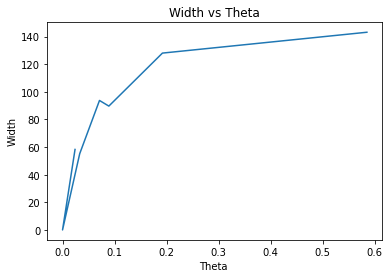

In [285]:
plt.plot(post_theta,widths)
plt.title("Width vs Theta")
plt.xlabel("Theta ")
plt.ylabel("Width")

Here the width is plotted against theta, we can see a relationship where as theta increases the width increases up until it rounds off. This represents a log curve. This can be thought of that as the probability that a detected exoplanet goes up, so does the error on that value.

Creating a Table to present the most likely value of theta and the width of the posterior for each distance "bin".

In [286]:
table = pd.DataFrame()
table["bin"] = ids
table["theta"] = post_theta
table["width"] = [round(i) for i in widths]

table

,bin,theta,width
0,1,0.585,143
1,2,0.192,128
2,3,0.089,90
3,4,0.071,94
4,5,0.033,55
5,6,0.000,0
6,7,0.000,0
7,8,0.024,58


Where bin 1 starts from 0 and bin 8 ends at 300 with intervals of 37.5.

It is known that ~70% of stars within the local neighbourhood within our Galaxy are M-dwarfs. How
do your results compare? Consider the limitations of the dataset and the biases in detection of
exoplanets.

I could not find a reference to "local neighbourhood within our Galaxy" and therefore could not determine which distances it refers to. However at no point in all the data that has been processed has the theta value been very close to 70% or 0.7. The closest theta value found in this analysis was in the first bin which covers the distances from 0 to 37.5 parsecs which had a theta value of 0.585 and therefore represents a 59% M_dwarf percentage. There is therefore a discrepancy between the actual value and the data that we have been provided. This can be explained from the squewedness of the data that has been given. The data contained a much larger number of non-M_dwarf orbiting exoplanets than the contrary and therefore leads to errors in the results when considering proportionalities between them (which is what gives the probabilites). We can therefore only use our data to comment on the catalog's data rather than the actual features in the Galaxy.

It was seen in the plot of theta vs distance that as the distance increases, the likelhood of the exoplanet datapoint in the data orbiting an M_dwarf decreased. This means that in the catalog of exoplanets, there is a relationship between the proportion of stars that are M_dwarfs and the distance from Earth, it does not suggest that as the distance increases that there are less M_dwarfs. The issue is just that the M_dwarfs become harder to detect and therefore there arent as many data point for these types of stars on the catalog. Therefore the data gives us information on the bias towards detecting different stars rather than the bias in actual stars that are in the Galaxy.

There are several scientific reasons for why M_dwarf stars become harder to detect the further away you are from Earth.

- One of the primary reasons is that M-dwarf stars are relatively faint, emitting less light compared to other star types such as G-type stars like our Sun. As the distance between us and the star increases, the amount of light reaching us decreases, making it more challenging to detect.

- M-dwarf stars are also typically found in the galactic disk of the Milky Way, which contains a considerable amount of dust and gas that can obscure the star's light. Since M-dwarf stars emit a lot of infrared light, observations need to be made at longer wavelengths that are less affected by the dust and gas. However, these observations require larger and more powerful telescopes.

- Furthermore, detecting the motion of M-dwarf stars can be challenging at greater distances. Since these stars are relatively small and cool, they emit most of their light in the infrared part of the spectrum. To measure their motion, astronomers need to observe the Doppler shift of their spectral lines, which is easier to do for brighter and closer stars.

- Overall, detecting M-dwarf stars at greater distances requires more advanced techniques, sensitive instruments, and more substantial telescopes to overcome the challenges posed by their low brightness, infrared emissions, and obscured light.